In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

# Getting the images compressed file from Google Drive and extracting

In [2]:
# !pip install gdown

In [3]:
# !gdown -O ../../datasets/ebay_boys_girls_shirts.tar.gz "https://drive.google.com/uc?id=14SgVvj6k12yXDJ82Qz4TdnqaaOBFjZj0"

In [4]:
# import tarfile
# with tarfile.open('../../datasets/ebay_boys_girls_shirts.tar.gz', "r:gz") as tar:
#     tar.extractall('../../datasets/')

# Once the images are extracted in `datasets` folder

In [5]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    folder = '../../datasets/ebay_boys_girls_shirts/'
    x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = get_final_matrices()

In [7]:
check_mem()

[('x_train', 600000112), ('x_test', 150000112), ('y_train', 160096), ('y_test', 40096), ('img_as_ubyte', 136), ('check_mem', 136), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


Our data matrices aren't that large because their `dtype` is unsigned int and we only took 10% of data:

In [8]:
print(x_train.dtype)

uint8


It's best to turn it to `float` in the 0-1 range, the size should still be OK (or you'll need to add more memory to your Docker/Azure machine):

In [9]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [10]:
check_mem()

[('x_train', 2400000112), ('x_test', 600000112), ('y_train', 160096), ('y_test', 40096), ('img_as_ubyte', 136), ('check_mem', 136), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


## Neural Network / Multi-Layer Perceptron (MLP)

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [12]:
batch_size = 128
epochs = 10

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

20000 train samples
5000 test samples


In [13]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(30000,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               15360512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
__________

In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',#RMSprop(),
              metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 28s 1ms/step - loss: 1.0818 - acc: 0.5094 - val_loss: 0.6880 - val_acc: 0.5002
Epoch 2/10
20000/20000 [==============================] - 27s 1ms/step - loss: 0.7032 - acc: 0.5233 - val_loss: 0.6891 - val_acc: 0.5472
Epoch 3/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.6833 - acc: 0.5593 - val_loss: 0.6703 - val_acc: 0.6376
Epoch 4/10
20000/20000 [==============================] - 28s 1ms/step - loss: 0.6548 - acc: 0.6009 - val_loss: 0.6050 - val_acc: 0.6968
Epoch 5/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.6209 - acc: 0.6596 - val_loss: 0.6076 - val_acc: 0.7076
Epoch 6/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.6102 - acc: 0.6737 - val_loss: 0.5778 - val_acc: 0.7226
Epoch 7/10
20000/20000 [==============================] - 29s 1ms/step - loss: 0.6063 - acc: 0.6789 - val_loss: 0.5968 - val_acc:

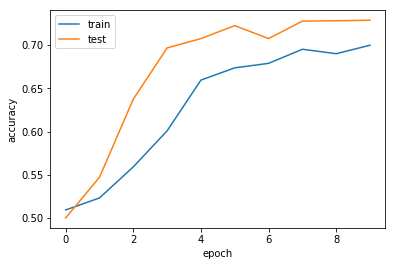

In [16]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')

## Convolutional Neural Network (CNN)

In [17]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [18]:
K.image_data_format()

'channels_last'

In [19]:
# input image dimensions
img_rows, img_cols, channels = 100, 100, 3

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
input_shape = (img_rows, img_cols, channels)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               18874496  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
__________

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 237s 12ms/step - loss: 0.6208 - acc: 0.7019 - val_loss: 0.4709 - val_acc: 0.7642
Epoch 2/10
20000/20000 [==============================] - 236s 12ms/step - loss: 0.4454 - acc: 0.7932 - val_loss: 0.4271 - val_acc: 0.8090
Epoch 3/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.3912 - acc: 0.8239 - val_loss: 0.4046 - val_acc: 0.8106
Epoch 4/10
20000/20000 [==============================] - 238s 12ms/step - loss: 0.3284 - acc: 0.8608 - val_loss: 0.3877 - val_acc: 0.8302
Epoch 5/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.2751 - acc: 0.8849 - val_loss: 0.4080 - val_acc: 0.8306
Epoch 6/10
20000/20000 [==============================] - 245s 12ms/step - loss: 0.2338 - acc: 0.9041 - val_loss: 0.3994 - val_acc: 0.8332
Epoch 7/10
20000/20000 [==============================] - 239s 12ms/step - loss: 0.1848 - acc: 0.9283 - val_loss: 0.4

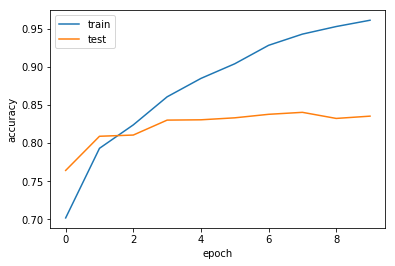

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')